In [32]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

### Script Structure:

* read in metadata file (sample_genus_and_species.csv)
* read in ska distances.distances.tsv
* data clean: 
    * make join key indeces consistent
    * assert no missing data
    * remove waters
 
* data reorganization:
    * create pivot table (with SNP_distance values) with multi-index including:
        * genus
        * species
        * corrected_species
        * sample_prefix

* visualizations
    * clustermap (with hierarchical clustering trees)
    * hierarchical clustering
    * do comparison graph to overlay most similar species for each comparison
        * organize color palette for similar species to show up in the same familiy of colors

* Data Output:
    * output entries that were potentially mislabeled
        * show clusters that are heterogeneous and output samples that were in the minority 
    
    
    
* create database, or grab other reference genomes for comparisons
        

In [79]:
# Data Collection

# load labels
species_id = pd.read_csv("~/code/skeeters/data/sample_genus_and_species.csv", header=0, index_col = 0)
# rename columns to have underscores
species_id.columns = species_id.columns.str.replace(" ", "_")
# create concat column for visualization 
species_id['genus_species'] = species_id.genus + " " + species_id.species
species_id['corrected_genus_species'] = species_id['corrected_genus'] + " " + species_id['corrected_species']
# rename index to join metadata onto correlation table
species_id.index = species_id.index + "_001"
species_id.head()

,genus,species,corrected_genus,corrected_species,genus_species,corrected_genus_species
CMS_001_RNA_A_S1_001,Culex,erythrothorax,Culex,erythrothorax,Culex erythrothorax,Culex erythrothorax
CMS_002_10a_Rb_S119_L004_001,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex quinquefasciatus,Culex quinquefasciatus
CMS_002_13a_Rb_S120_L004_001,Culex,quinquefasciatus,Culex,quinquefasciatus,Culex quinquefasciatus,Culex quinquefasciatus
CMS_002_16a_Rb_S121_L004_001,Aedes,aegypti,Aedes,aegypti,Aedes aegypti,Aedes aegypti
CMS_002_17a_Rb_S122_L004_001,Aedes,aegypti,Aedes,aegypti,Aedes aegypti,Aedes aegypti


In [80]:
def merge_data(distances_tsv):
    '''join labels onto distance matrices'''
    
    # read in data tables with sample distances computed with ska (split kmer analysis)
    dd_tsv = pd.read_csv(distances_tsv, sep='\t')
    dd_tsv.columns = dd_tsv.columns.str.replace(" ", "_")
    shape_dd_tsv = dd_tsv.shape

    # Add prefix columns and size
    dd_tsv["sample_1_prefix"] = dd_tsv.apply(lambda row: row["Sample_1"].split("_10000000")[0], axis=1)
    dd_tsv["sample_2_prefix"] = dd_tsv.apply(lambda row: row["Sample_2"].split("_10000000")[0], axis=1)
    dd_tsv["Size"] = dd_tsv.apply(lambda row: row["Sample_2"].split("_")[-1], axis=1)

    # drop to keep only prefix sample names
    dd_tsv.drop(['Sample_1', 'Sample_2'], axis=1)

    # re-organize columns
    dd_tsv = dd_tsv[["sample_1_prefix", 
                     "sample_2_prefix", 
                     "Size", 
                     "Matches", 
                     "Mismatches", 
                     "Jaccard_Index",
                     "Mash-like_distance",
                     "SNPs",
                     "SNP_distance",
                    ]]

    # join on labels from species data table
    dd_tsv_w_labels = pd.merge(
        dd_tsv, 
        species_id[["genus", "species", "corrected_species"]], 
        how='left',
        left_on="sample_1_prefix", 
        right_index=True, 
    )
    
    #if assert shape_dd_tsv[0] == dd_tsv_w_labels.shape[0]:
    # remove data with no species label
    dd_tsv_w_labels = dd_tsv_w_labels[dd_tsv_w_labels.species.notnull()]
    return dd_tsv_w_labels


,sample_1_prefix,sample_2_prefix,Size,Matches,Mismatches,Jaccard_Index,Mash-like_distance,SNPs,SNP_distance,genus,species,corrected_species


In [19]:
dd_tsv_w_labels.head(n=10)

,sample_1_prefix,sample_2_prefix,Size,Matches,Mismatches,Jaccard_Index,Mash-like_distance,SNPs,SNP_distance,genus,species,corrected_species
0,CMS_001_RNA_A_S1_001,CMS_002_10a_Rb_S119_L004_001,10000000,107591,796458,0.119010,0.049930,590,0.005484,Culex,erythrothorax,erythrothorax
1,CMS_001_RNA_A_S1_001,CMS_002_13a_Rb_S120_L004_001,10000000,124812,898057,0.122021,0.049211,683,0.005472,Culex,erythrothorax,erythrothorax
2,CMS_001_RNA_A_S1_001,CMS_002_16a_Rb_S121_L004_001,10000000,64767,1005138,0.060535,0.070005,591,0.009125,Culex,erythrothorax,erythrothorax
3,CMS_001_RNA_A_S1_001,CMS_002_17a_Rb_S122_L004_001,10000000,67326,950575,0.066142,0.067318,585,0.008689,Culex,erythrothorax,erythrothorax
4,CMS_001_RNA_A_S1_001,CMS_002_17b_Rb_S123_L004_001,10000000,68380,970402,0.065827,0.067462,593,0.008672,Culex,erythrothorax,erythrothorax
5,CMS_001_RNA_A_S1_001,CMS_002_17c_Rb_S124_L004_001,10000000,70698,1042362,0.063517,0.068545,620,0.008770,Culex,erythrothorax,erythrothorax
6,CMS_001_RNA_A_S1_001,CMS_002_17d_Rb_S125_L004_001,10000000,66111,960476,0.064399,0.068126,553,0.008365,Culex,erythrothorax,erythrothorax
7,CMS_001_RNA_A_S1_001,CMS_002_17e_Rb_S126_L004_001,10000000,67631,917250,0.068669,0.066185,585,0.008650,Culex,erythrothorax,erythrothorax
8,CMS_001_RNA_A_S1_001,CMS_002_18a_Rb_S128_L004_001,10000000,65172,945949,0.064455,0.068100,616,0.009452,Culex,erythrothorax,erythrothorax
9,CMS_001_RNA_A_S1_001,CMS_002_18b_Rb_S129_L004_001,10000000,71185,1047853,0.063613,0.068499,651,0.009145,Culex,erythrothorax,erythrothorax


In [81]:
def create_pivot(df, values="SNP_distance"):    
    # create pivot tables with sample 1 and sample 2 correlations
    dd_tsv_pivot = df.pivot(columns="sample_1_prefix", index="sample_2_prefix", values=values)
    dd_tsv_pivot = dd_tsv_pivot.loc[dd_tsv_pivot.columns, :]
    np.fill_diagonal(dd_tsv_pivot.values, 0)
    dd_tsv_pivot = dd_tsv_pivot.fillna(0) + dd_tsv_pivot.T.fillna(0) - np.diag(dd_tsv_pivot.values.diagonal())
    return dd_tsv_pivot


def pivot_metadata(df):
    
    dd_tsv_pivot_w_labels = pd.merge(
        df, 
        species_id[["genus", "species", "corrected_species"]], 
        how='inner',
        left_index=True, 
        right_index=True, 
    )
    
    dd_tsv_pivot_w_labels.reset_index(inplace=True)
    dd_tsv_pivot_w_labels.set_index(["index", "genus", "species", "corrected_species"], inplace=True)
    
    return dd_tsv_pivot_w_labels


In [137]:
fp = "sketches/ska/10000000/distances.distances.tsv"
dd_tsv_w_labels = merge_data(fp)
dd_tsv_pivot = create_pivot(dd_tsv_w_labels)
dd_pivot_w_labels = pivot_metadata(dd_tsv_pivot) 
dd_pivot_w_labels.head()

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,,,,CMS_001_RNA_A_S1_001,CMS_002_10a_Rb_S119_L004_001,CMS_002_13a_Rb_S120_L004_001,CMS_002_16a_Rb_S121_L004_001,CMS_002_17a_Rb_S122_L004_001,CMS_002_17b_Rb_S123_L004_001,CMS_002_17c_Rb_S124_L004_001,CMS_002_17d_Rb_S125_L004_001,CMS_002_17e_Rb_S126_L004_001,CMS_002_18a_Rb_S128_L004_001,...,CMS_050_RNA_A_S23_001,CMS_051_RNA_A_S8_001,CMS_052_RNA_A_S7_001,CMS_053_RNA_A_S8_001,CMS_054_RNA_A_S11_001,CMS_055_RNA_A_S9_001,CMS_056_RNA_A_S10_001,CMS_057_RNA_A_S11_001,CMS_059_RNA_A_S10_001,CMS_060_RNA_A_S12_001
index,genus,species,corrected_species,,,,,,,,,,,,,,,,,,,,,
CMS_001_RNA_A_S1_001,Culex,erythrothorax,erythrothorax,0.000000,0.005484,0.005472,0.009125,0.008689,0.008672,0.008770,0.008365,0.008650,0.009452,...,0.000329,0.003989,0.000412,0.000305,0.001194,0.000219,0.000507,0.000739,0.003337,0.007052
CMS_002_10a_Rb_S119_L004_001,Culex,quinquefasciatus,quinquefasciatus,0.005484,0.000000,0.000618,0.008814,0.008603,0.008629,0.009062,0.008560,0.008013,0.008719,...,0.005385,0.005254,0.004603,0.004868,0.000936,0.003216,0.004129,0.004275,0.001831,0.010461
CMS_002_13a_Rb_S120_L004_001,Culex,quinquefasciatus,quinquefasciatus,0.005472,0.000618,0.000000,0.008629,0.007973,0.008325,0.008056,0.008173,0.007629,0.008985,...,0.005731,0.004868,0.004966,0.005401,0.001224,0.003620,0.004615,0.004655,0.002002,0.010326
CMS_002_16a_Rb_S121_L004_001,Aedes,aegypti,aegypti,0.009125,0.008814,0.008629,0.000000,0.000489,0.000498,0.000450,0.000427,0.000470,0.000604,...,0.008967,0.007872,0.008697,0.008725,0.005555,0.008408,0.007767,0.007807,0.008707,0.009826
CMS_002_17a_Rb_S122_L004_001,Aedes,aegypti,aegypti,0.008689,0.008603,0.007973,0.000489,0.000000,0.000453,0.000416,0.000255,0.000443,0.000576,...,0.008377,0.007580,0.008823,0.008679,0.005736,0.007620,0.007510,0.007429,0.008378,0.009119


In [143]:
linkage = get_linkage(dd_pivot_w_labels)
cluster_map_labels = get_cluster_map(dd_pivot_w_labels, linkage, 12)

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [144]:
cluster_map_labels

,genus,species,corrected_species,cluster,corrected_ska
sample_prefix,,,,,
CMS_001_RNA_A_S1_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_28a_Rb_S154_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_28b_Rb_S155_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_28c_Rb_S156_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_28d_Rb_S157_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_28e_Rb_S158_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_47a_Rb_S193_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_47b_Rb_S194_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax
CMS_002_47c_Rb_S195_L004_001,Culex,erythrothorax,erythrothorax,7,erythrothorax


In [147]:
df2 = pd.merge(
        dd_pivot_w_labels, 
        cluster_map_labels[["corrected_ska"]], 
        how='inner',
        left_on=dd_pivot_w_labels.index.get_level_values(0),
        right_on=cluster_map_labels.index.get_level_values(0)
    )
df2.head()

,key_0,CMS_001_RNA_A_S1_001,CMS_002_10a_Rb_S119_L004_001,CMS_002_13a_Rb_S120_L004_001,CMS_002_16a_Rb_S121_L004_001,CMS_002_17a_Rb_S122_L004_001,CMS_002_17b_Rb_S123_L004_001,CMS_002_17c_Rb_S124_L004_001,CMS_002_17d_Rb_S125_L004_001,CMS_002_17e_Rb_S126_L004_001,...,CMS_051_RNA_A_S8_001,CMS_052_RNA_A_S7_001,CMS_053_RNA_A_S8_001,CMS_054_RNA_A_S11_001,CMS_055_RNA_A_S9_001,CMS_056_RNA_A_S10_001,CMS_057_RNA_A_S11_001,CMS_059_RNA_A_S10_001,CMS_060_RNA_A_S12_001,corrected_ska
0,CMS_001_RNA_A_S1_001,0.000000,0.005484,0.005472,0.009125,0.008689,0.008672,0.008770,0.008365,0.008650,...,0.003989,0.000412,0.000305,0.001194,0.000219,0.000507,0.000739,0.003337,0.007052,erythrothorax
1,CMS_002_10a_Rb_S119_L004_001,0.005484,0.000000,0.000618,0.008814,0.008603,0.008629,0.009062,0.008560,0.008013,...,0.005254,0.004603,0.004868,0.000936,0.003216,0.004129,0.004275,0.001831,0.010461,quinquefasciatus
2,CMS_002_13a_Rb_S120_L004_001,0.005472,0.000618,0.000000,0.008629,0.007973,0.008325,0.008056,0.008173,0.007629,...,0.004868,0.004966,0.005401,0.001224,0.003620,0.004615,0.004655,0.002002,0.010326,quinquefasciatus
3,CMS_002_16a_Rb_S121_L004_001,0.009125,0.008814,0.008629,0.000000,0.000489,0.000498,0.000450,0.000427,0.000470,...,0.007872,0.008697,0.008725,0.005555,0.008408,0.007767,0.007807,0.008707,0.009826,aegypti
4,CMS_002_17a_Rb_S122_L004_001,0.008689,0.008603,0.007973,0.000489,0.000000,0.000453,0.000416,0.000255,0.000443,...,0.007580,0.008823,0.008679,0.005736,0.007620,0.007510,0.007429,0.008378,0.009119,aegypti


/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genus,species,corrected_species,cluster,corrected_ska
sample_prefix,,,,,
CMS_002_53a_Rb_S7_L004_001,Culex,pipiens,pipiens,7,erythrothorax
CMS_045_RNA_A_S2_001,Culex,tarsalis,erythrothorax,7,erythrothorax
CMS_025_RNA_A_S7_001,Culex,tarsalis,particeps,5,particeps
CMS_002_7a_Rb_S118_L004_001,Culex,quinquefasciatus,quinquefasciatus,3,incidens
CMS_026_RNA_A_S18_001,Culex,tarsalis,incidens,3,incidens


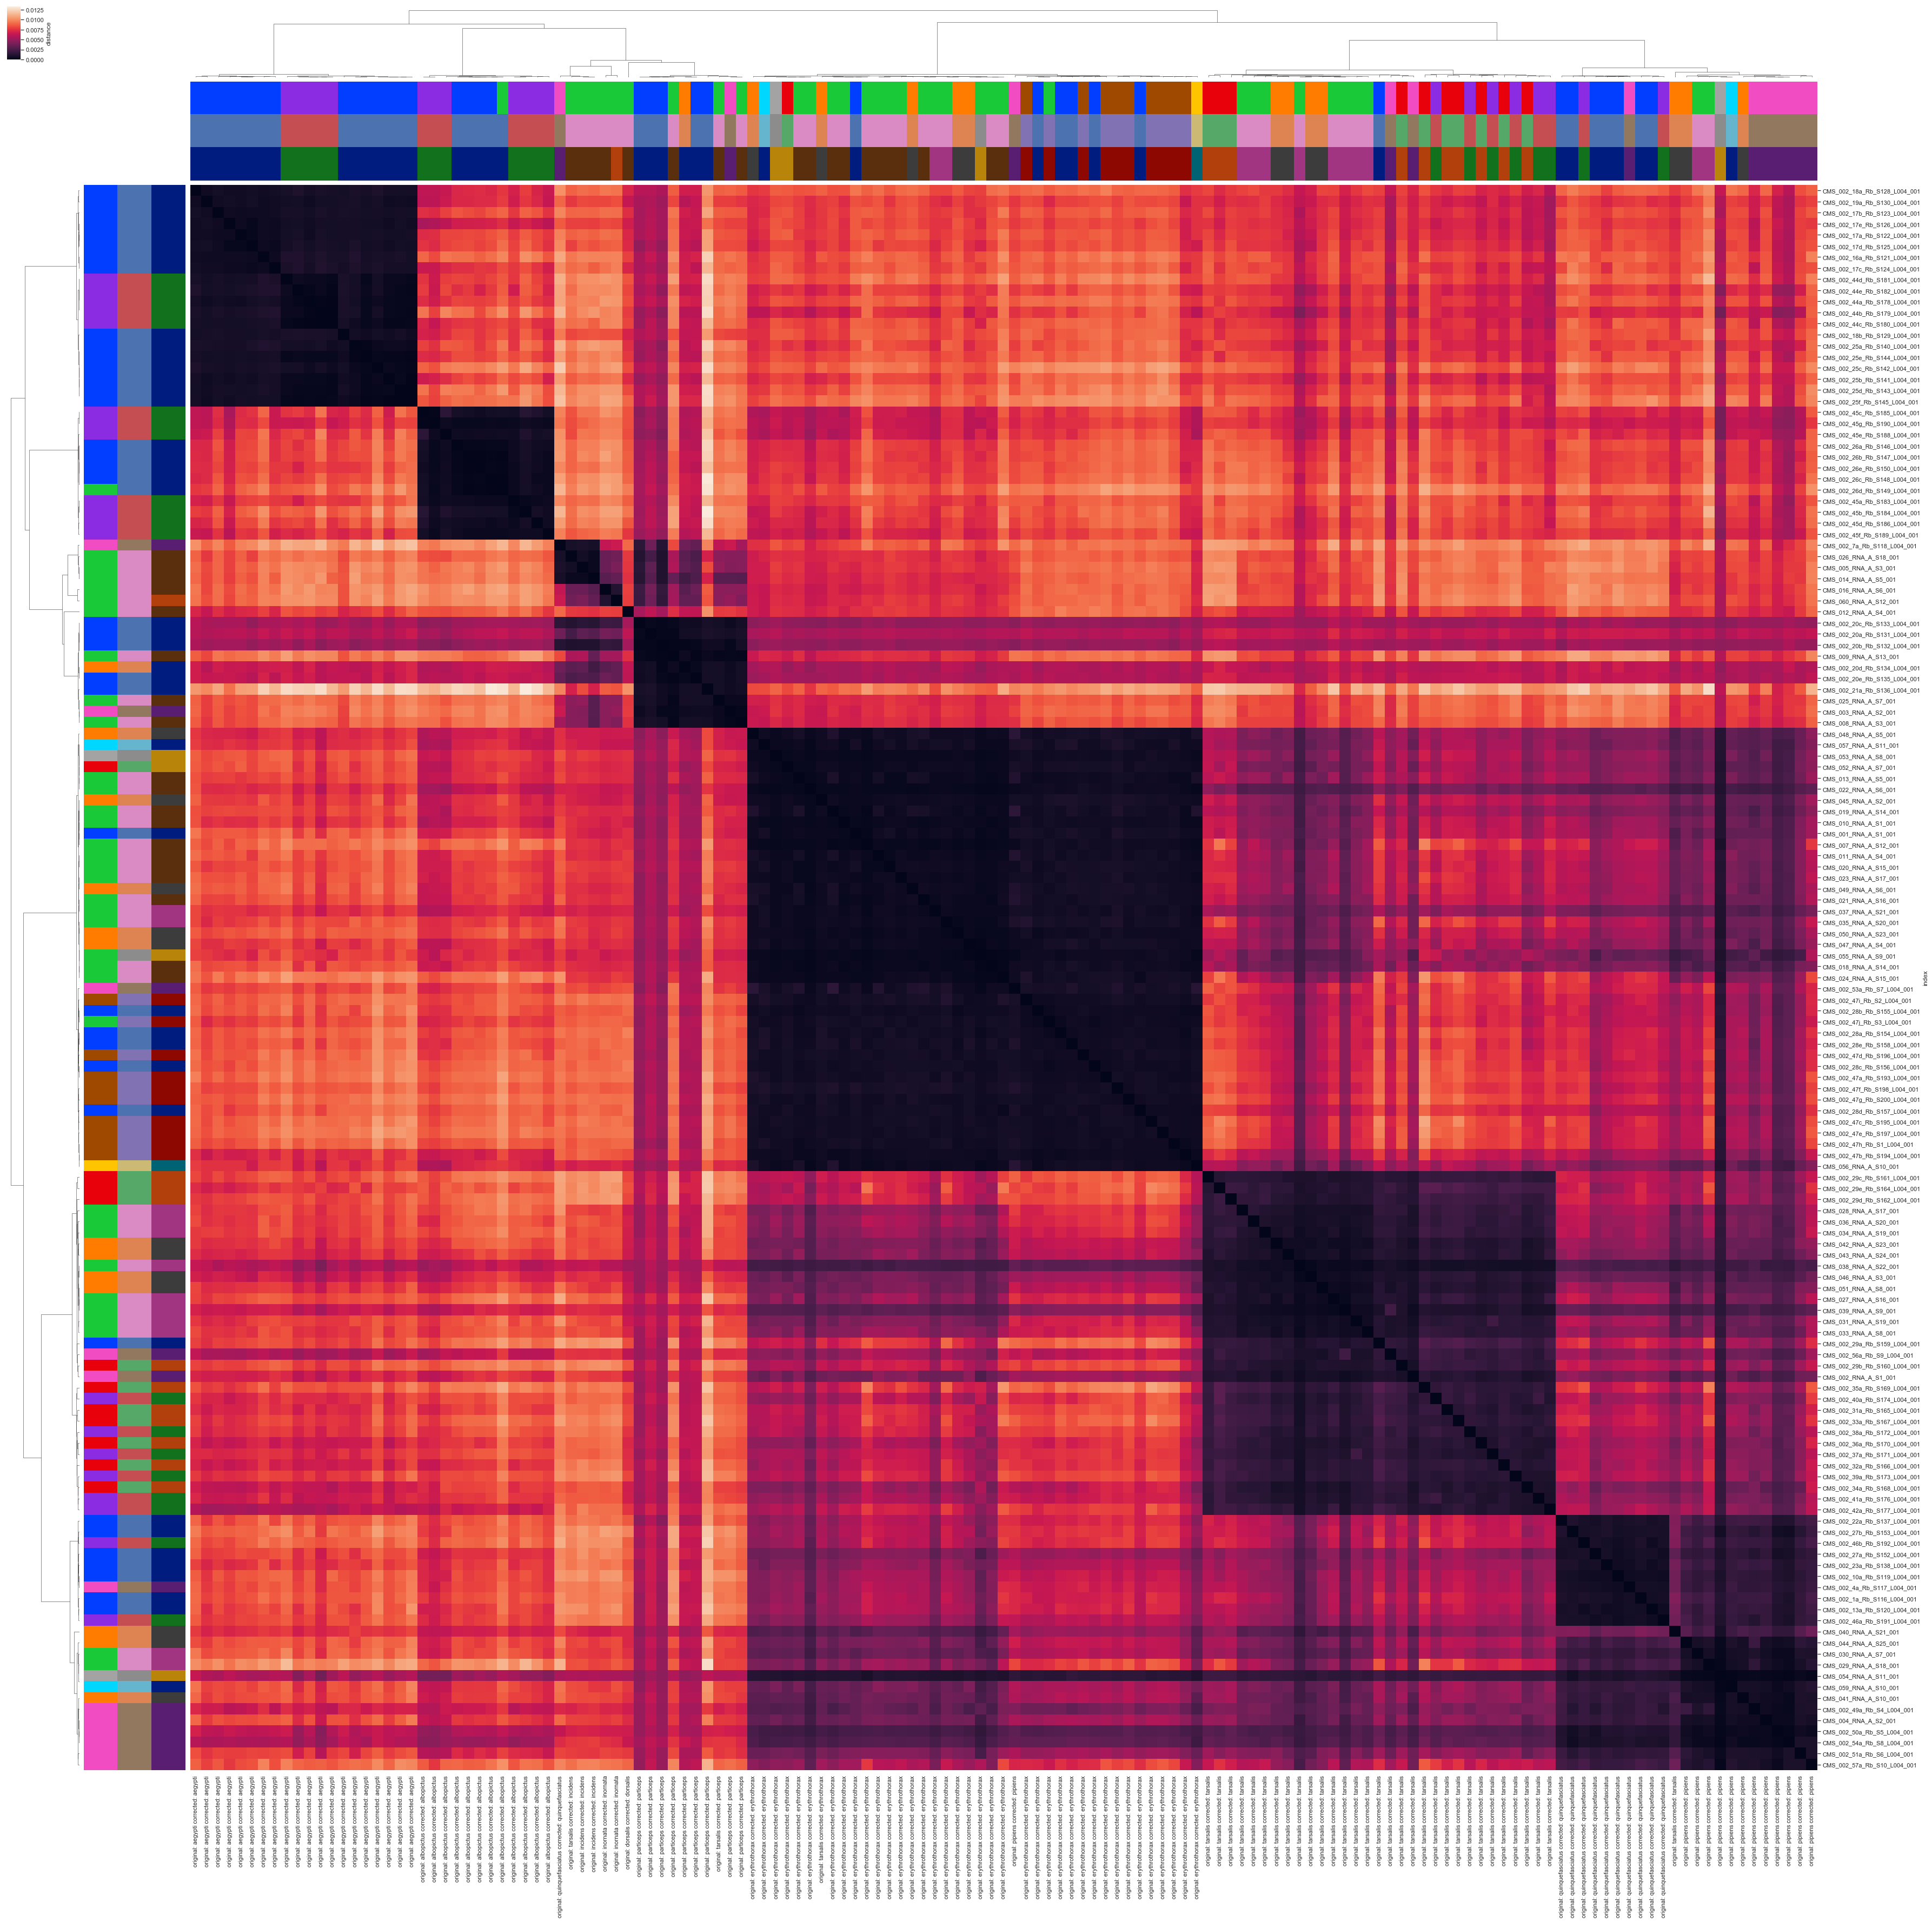

In [157]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# cdist = scipy.spatial.distance.squareform(dd_tsv_pivot_w_labels)
# linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")

# ward = AgglomerativeClustering(
#     n_clusters=12, 
#     affinity = 'precomputed',
#     linkage='complete'
# )

# clusters = ward.fit(dd_tsv_pivot_w_labels)


def correlation_matrix(pivot_w_labels, linkage, cluster_map):

    
    original_species_coloring = dict(zip(cluster_map.species.unique(), sns.color_palette("bright", 12)))
    corrected_species_coloring = dict(zip(cluster_map.corrected_species.unique(), sns.color_palette("deep", 12)))
    genus_coloring = dict(zip(cluster_map.genus.unique(), sns.color_palette("husl", 4)))
    ska_corrected_coloring = dict(zip(cluster_map.cluster.unique(), sns.color_palette("dark", 13)))
    
    key_colors_species = cluster_map["species"].map(original_species_coloring)
    key_colors_corrected_species = cluster_map["corrected_species"].map(corrected_species_coloring)
    key_colors_genus = cluster_map["genus"].map(genus_coloring)
    key_colors_ska_corrected = cluster_map["cluster"].map(ska_corrected_coloring)
    
    key_colors_labels = [key_colors_species, key_colors_corrected_species, key_colors_ska_corrected]
    
#     labels = []
#     for i in pivot_w_labels.index.get_level_values(2):
#         if pivot_w_labels.index.get_level_values(2)
#     labels = "original: " + pivot_w_labels.index.get_level_values(2) + " corrected: " + pivot_w_labels.index.get_level_values(3)

    return sns.clustermap(
            #pivot_w_labels, 
            pivot_w_labels.reset_index().drop([
                "genus", 
                "species", 
                "corrected_species"
            ], axis=1).set_index("index"),
            metric="correlation", 
            row_colors=key_colors_labels, 
            col_colors=key_colors_labels,
            figsize = (60,60),
            col_linkage = linkage,
            row_linkage = linkage,
            cbar_kws = {'label': 'distance'},
            xticklabels= "original: " + pivot_w_labels.index.get_level_values(2) + " corrected: " + pivot_w_labels.index.get_level_values(3),
            yticklabels= pivot_w_labels.index.get_level_values(0)
    )


def get_linkage(pivot_df):
    cdist = scipy.spatial.distance.squareform(pivot_df)
    return scipy.cluster.hierarchy.linkage(cdist, method="ward")


def get_cluster_map(pivot_df, linkage, num_clusters):
    clusters = fcluster(linkage, num_clusters, criterion='maxclust')
    cluster_map = pd.DataFrame()
    cluster_map['genus']   = pivot_df.index.get_level_values(1)
    cluster_map['species'] = pivot_df.index.get_level_values(2)
    cluster_map['corrected_species'] = pivot_df.index.get_level_values(3)
    cluster_map["sample_prefix"] = pivot_df.columns
    cluster_map['cluster'] = clusters
    cluster_map.set_index("sample_prefix", inplace=True)
    return cluster_map


def output_mismatches(cluster_map):  
    cm2 = cluster_map.copy()
    cm2_chunks = []
    for clust in cm2.cluster.unique():
        subset = cm2[cm2.cluster == clust]
        mode = subset.species.mode()[0]
        subset["corrected_ska"] = mode
        cm2_chunks.append(subset)

    return pd.concat(cm2_chunks)
    
    return cluster_map_w_ska.query('species != corrected_species | species != corrected_ska | corrected_species != corrected_ska')


def cluster_to_heatmap(fp, index="species", index_vals=[], k=12):
    dd_tsv_w_labels = merge_data(fp)
    dd_tsv_w_labels[dd_tsv_w_labels.species.isnull()]
    
    if len(index_vals) > 0:
        dd_tsv_w_labels = dd_tsv_w_labels[dd_tsv_w_labels[index].isin(index_vals)]
        k = len(index_vals)
        
    dd_tsv_pivot = create_pivot(dd_tsv_w_labels)
    dd_pivot_w_labels = pivot_metadata(dd_tsv_pivot) 
    linkage = get_linkage(dd_pivot_w_labels)
    cluster_map_labels = get_cluster_map(dd_pivot_w_labels, linkage, 12)
    cluster_map_viz = get_cluster_map(dd_pivot_w_labels, linkage, k)
    g = correlation_matrix(dd_pivot_w_labels, linkage, cluster_map_viz)
    return cluster_map_labels.query('species != corrected_species | species != corrected_ska | corrected_species != corrected_ska')
    
cluster_to_heatmap("sketches/ska/10000000/distances.distances.tsv")    

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genus,species,corrected_species,cluster,corrected_ska
sample_prefix,,,,,
CMS_045_RNA_A_S2_001,Culex,tarsalis,erythrothorax,9,pipiens
CMS_026_RNA_A_S18_001,Culex,tarsalis,incidens,7,quinquefasciatus
CMS_025_RNA_A_S7_001,Culex,tarsalis,particeps,8,tarsalis


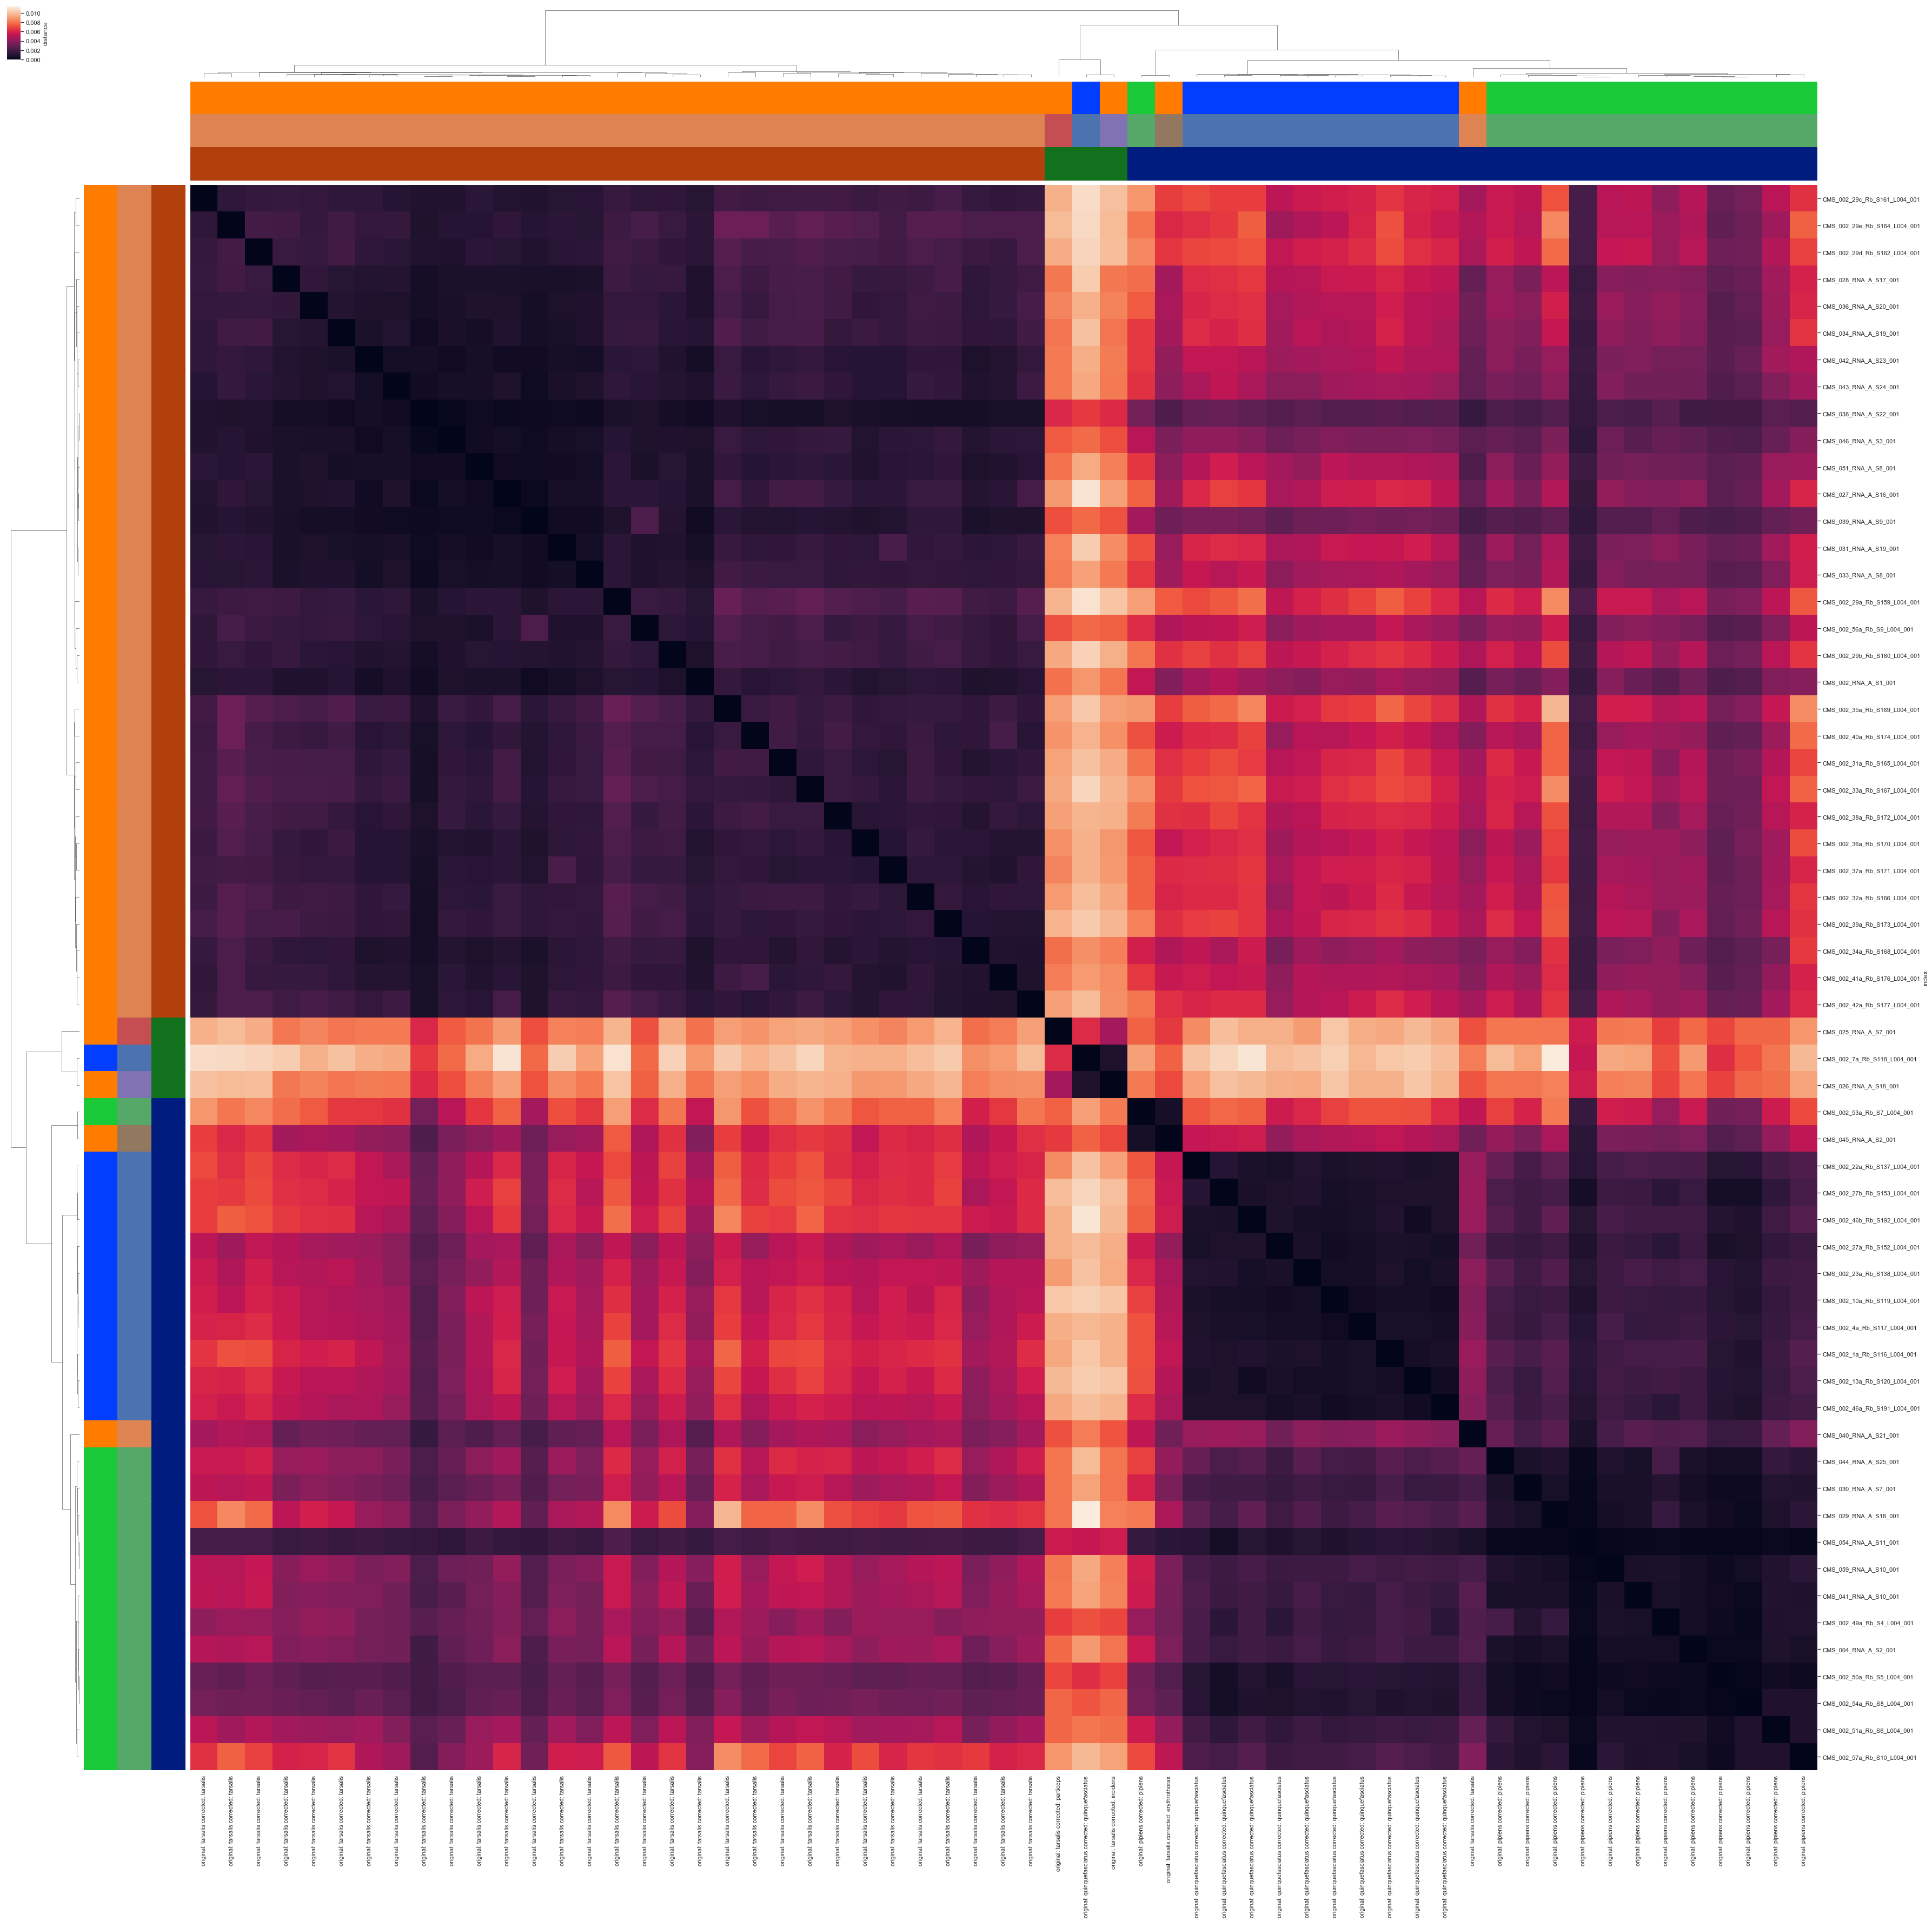

In [132]:
cluster_to_heatmap("sketches/ska/10000000/distances.distances.tsv", index_vals=["pipiens", "tarsalis", "quinquefasciatus"])  

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genus,species,corrected_species,cluster,corrected_ska
sample_prefix,,,,,


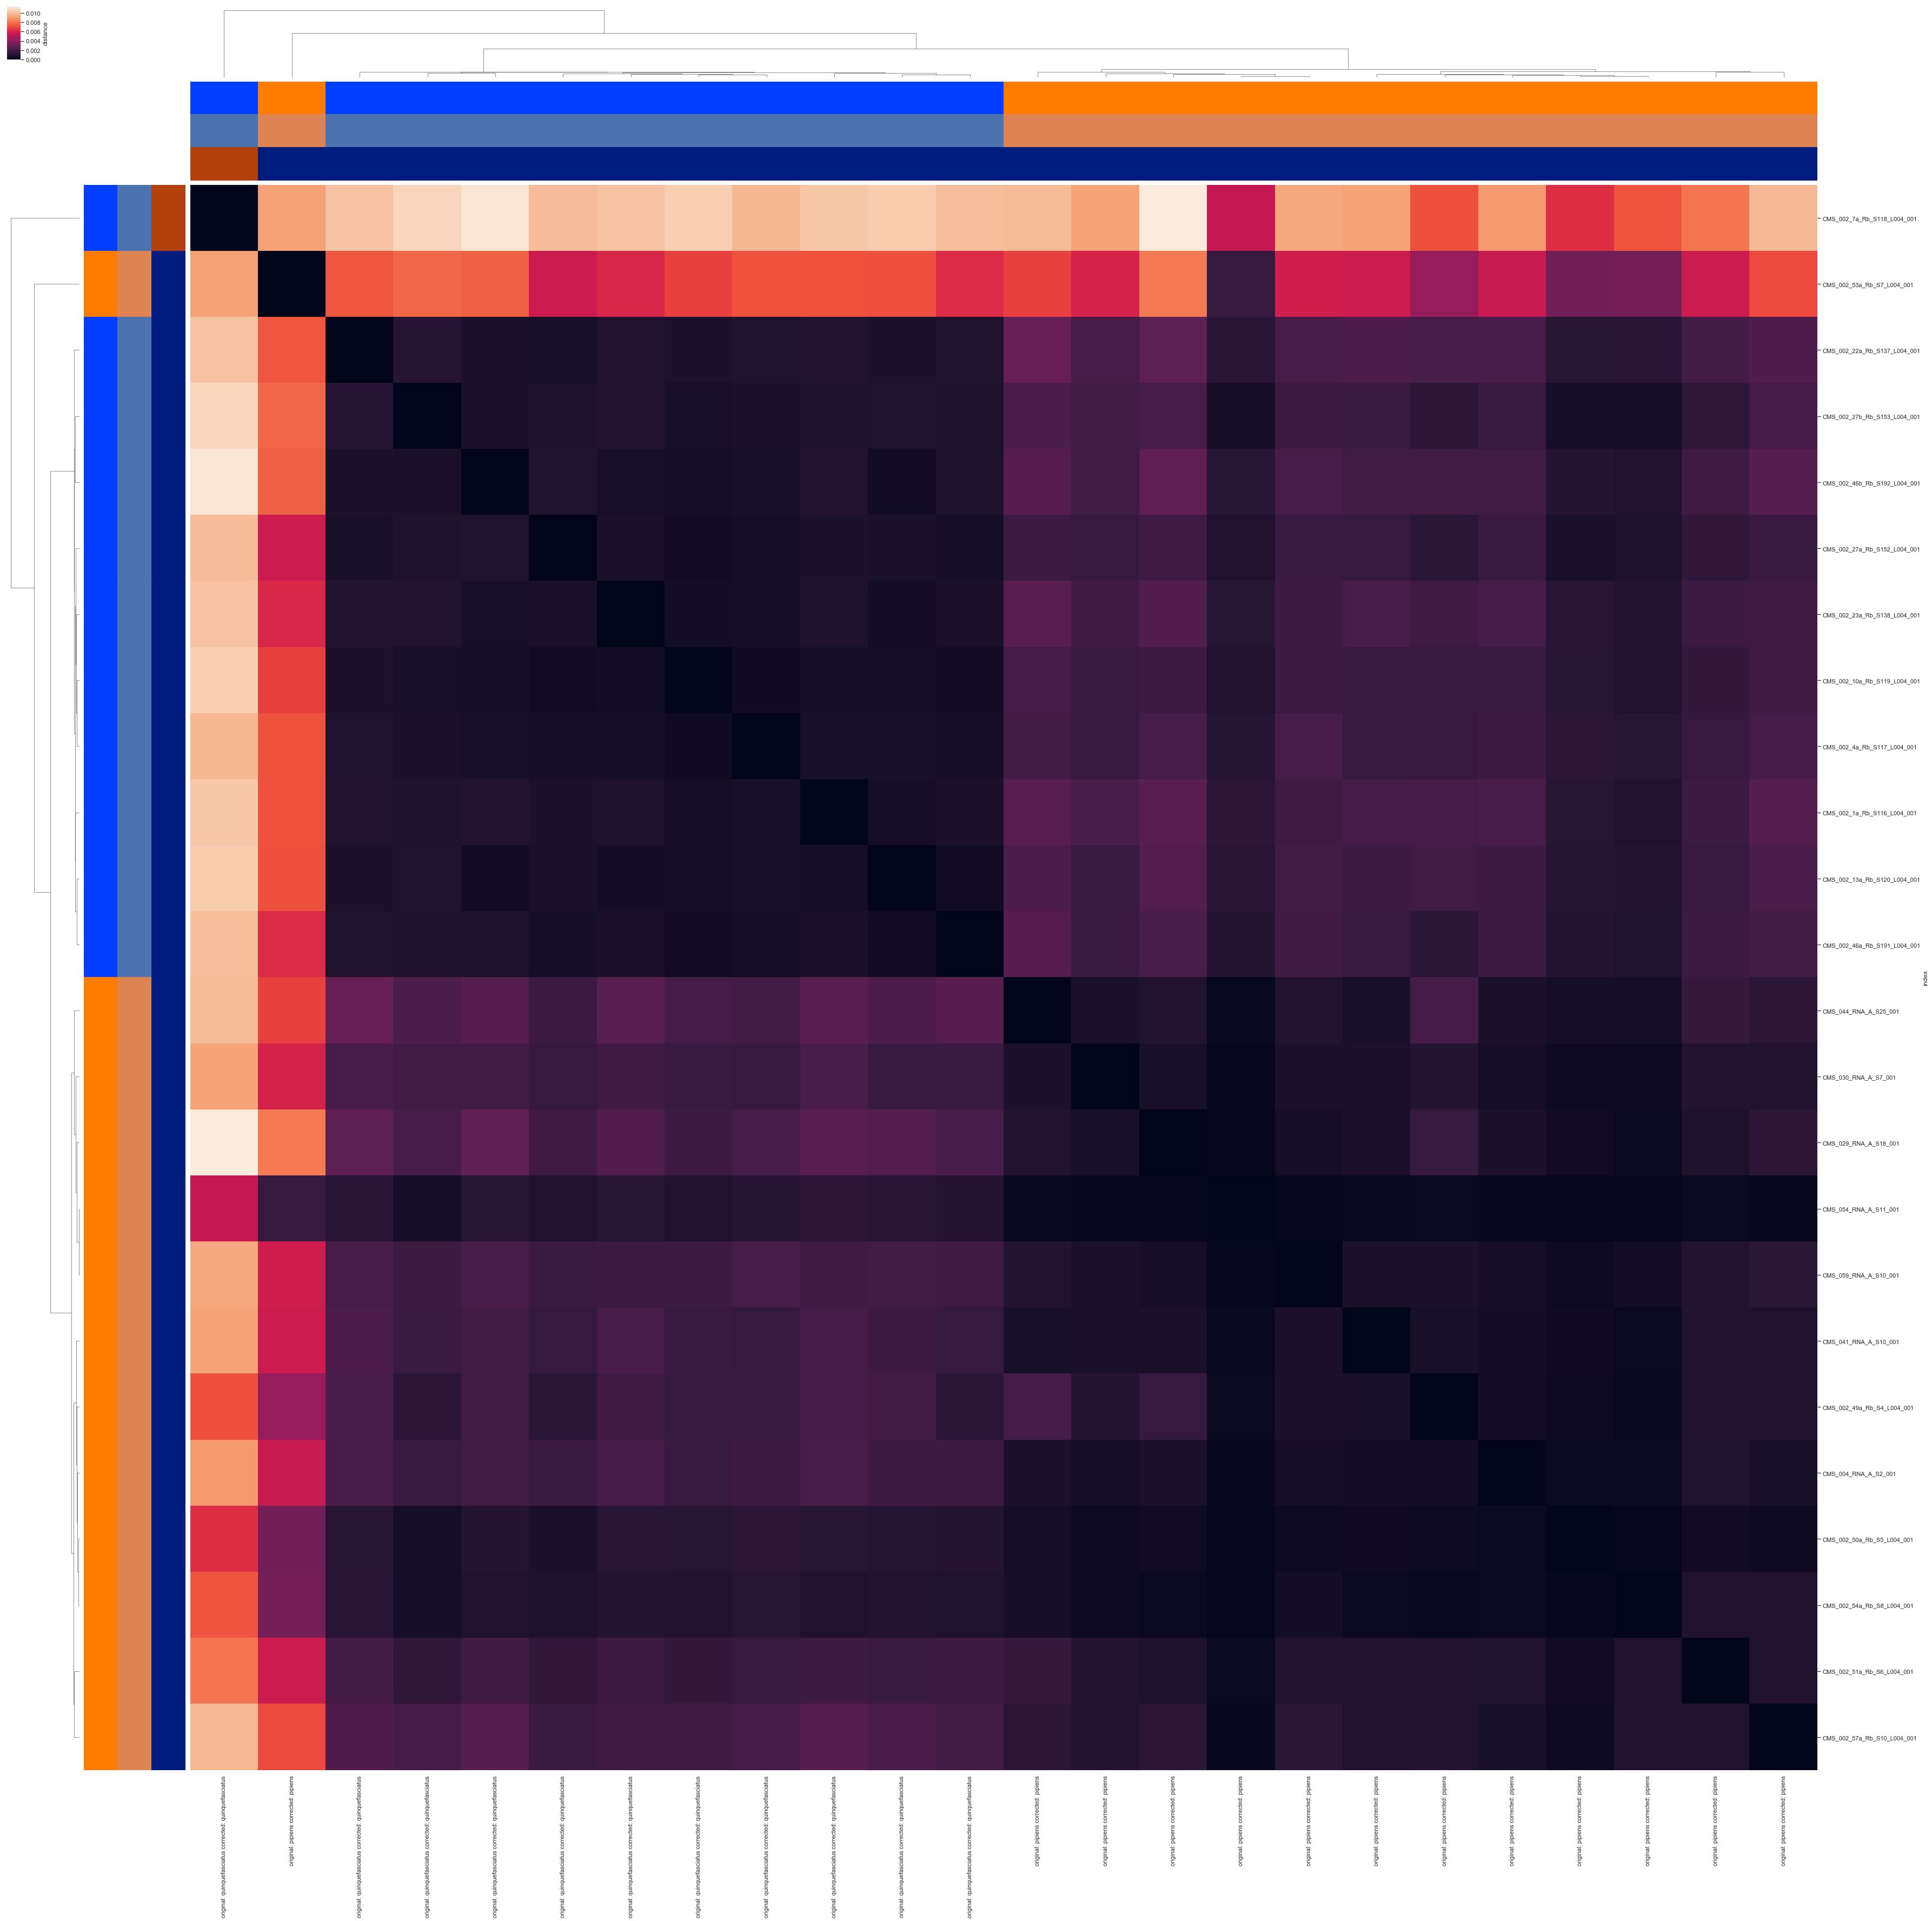

In [133]:
cluster_to_heatmap("sketches/ska/10000000/distances.distances.tsv", index_vals=["pipiens", "quinquefasciatus"])  

/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/phoenix.logan/anaconda3/envs/ska/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,genus,species,corrected_species,cluster,corrected_ska
sample_prefix,,,,,


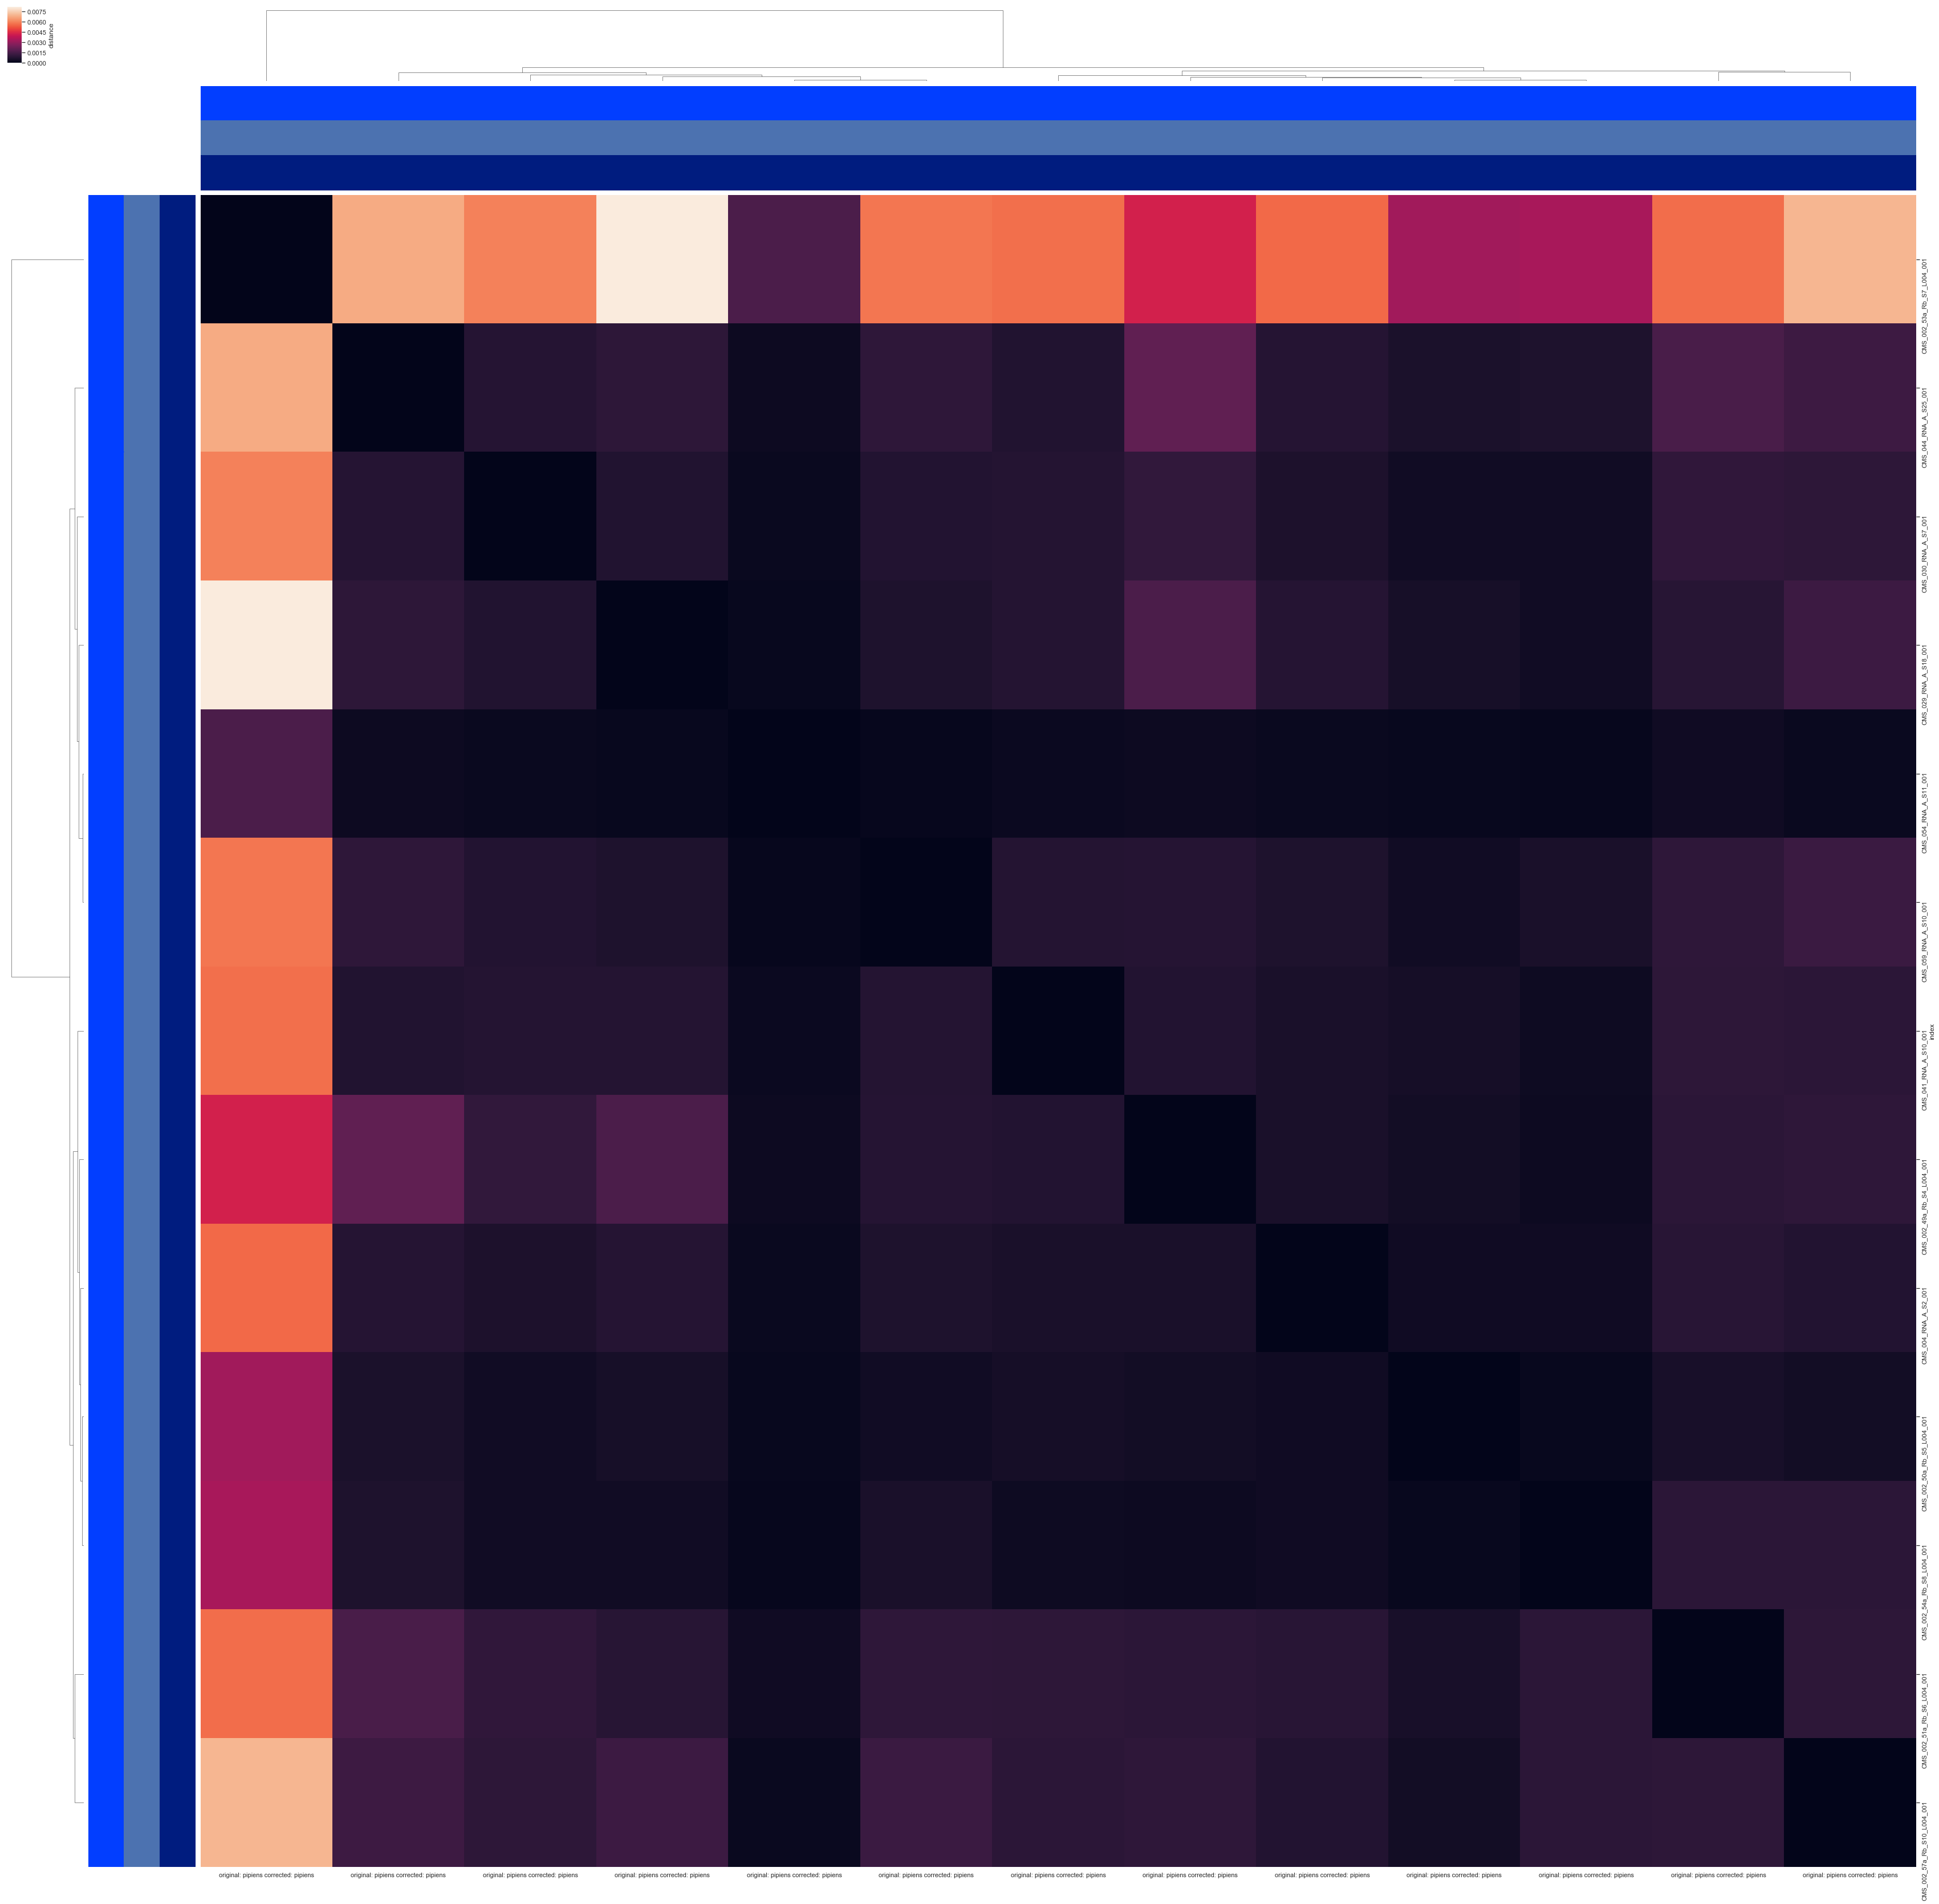

In [134]:
cluster_to_heatmap("sketches/ska/10000000/distances.distances.tsv", index_vals=["pipiens"]) 


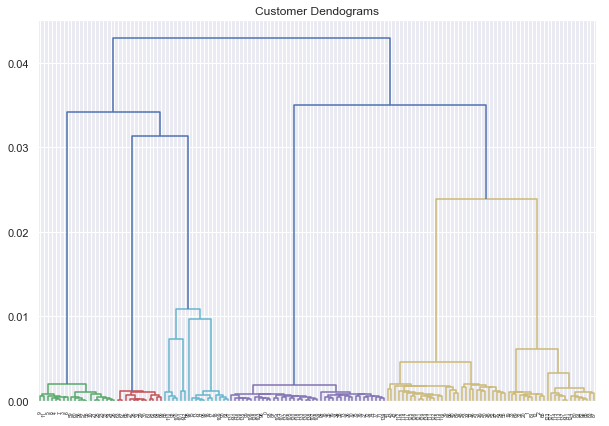

In [51]:
import scipy.cluster.hierarchy as shc

# cdist = scipy.spatial.distance.squareform(dd_pivot_w_labels_corrected_species)
# linkage = scipy.cluster.hierarchy.linkage(cdist, method="ward")

plt.figure(figsize=(10, 7))  
plt.title("species_cluster")
#plt.xlabel(dd_pivot_w_labels_corrected_species.index.get_level_values(2))
dend = shc.dendrogram(linkage)

In [118]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage, 12, criterion='maxclust')
clusters

array([ 7, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10,  5,  5,  5,  5,
        5,  5, 10, 10,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2, 10, 10,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
       10, 10,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7, 11, 10, 11, 11,  7,
       11,  8, 11,  3,  8,  5, 11,  3,  7,  5,  5,  7,  7,  6,  7,  3,  4,
        7,  7,  7,  7,  7,  7,  7,  5,  3,  8,  8, 11, 11,  8,  8,  8,  7,
        8,  7,  8,  8, 12, 11,  8,  8, 11,  7,  8,  7,  7,  7,  7,  8,  7,
        7, 11,  7,  7,  7, 11,  4], dtype=int32)

/Users/phoenix.logan/code/kh-tools/khtools/sourmash_utils.py:141: UserWarning: 'polo' not installed! Dendrogram will not be optimal leaf ordered. Install with 'pip install polo'
  warnings.warn("'polo' not installed! Dendrogram will not be optimal "
/Users/phoenix.logan/code/kh-tools/khtools/sourmash_utils.py:141: UserWarning: 'polo' not installed! Dendrogram will not be optimal leaf ordered. Install with 'pip install polo'
  warnings.warn("'polo' not installed! Dendrogram will not be optimal "


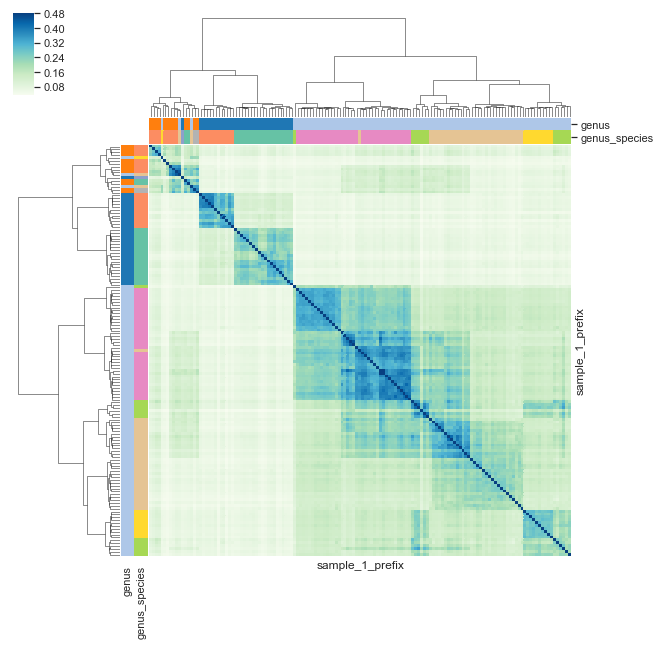

In [156]:
from khtools import sourmash_utils

metadata_cols =["genus", 'genus_species']
palette=dict(genus="tab20", genus_species='Set2')

sourmash_utils.plaidplot_square(dd_tsv_pivot, species_id, 
                                metadata_col= metadata_cols,
                                palette=palette
                                )

/Users/phoenix.logan/code/kh-tools/khtools/sourmash_utils.py:141: UserWarning: 'polo' not installed! Dendrogram will not be optimal leaf ordered. Install with 'pip install polo'
  warnings.warn("'polo' not installed! Dendrogram will not be optimal "
/Users/phoenix.logan/code/kh-tools/khtools/sourmash_utils.py:141: UserWarning: 'polo' not installed! Dendrogram will not be optimal leaf ordered. Install with 'pip install polo'
  warnings.warn("'polo' not installed! Dendrogram will not be optimal "


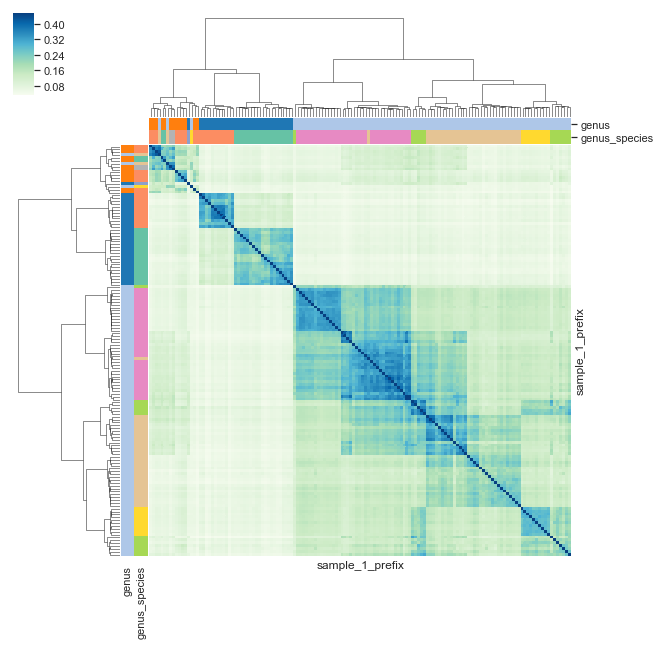

In [157]:
sourmash_utils.plaidplot_square(dd_tsv_pivot_21, species_id, 
                                metadata_col= metadata_cols,
                                palette=palette
                                )

/Users/phoenix.logan/code/kh-tools/khtools/sourmash_utils.py:141: UserWarning: 'polo' not installed! Dendrogram will not be optimal leaf ordered. Install with 'pip install polo'
  warnings.warn("'polo' not installed! Dendrogram will not be optimal "
/Users/phoenix.logan/code/kh-tools/khtools/sourmash_utils.py:141: UserWarning: 'polo' not installed! Dendrogram will not be optimal leaf ordered. Install with 'pip install polo'
  warnings.warn("'polo' not installed! Dendrogram will not be optimal "


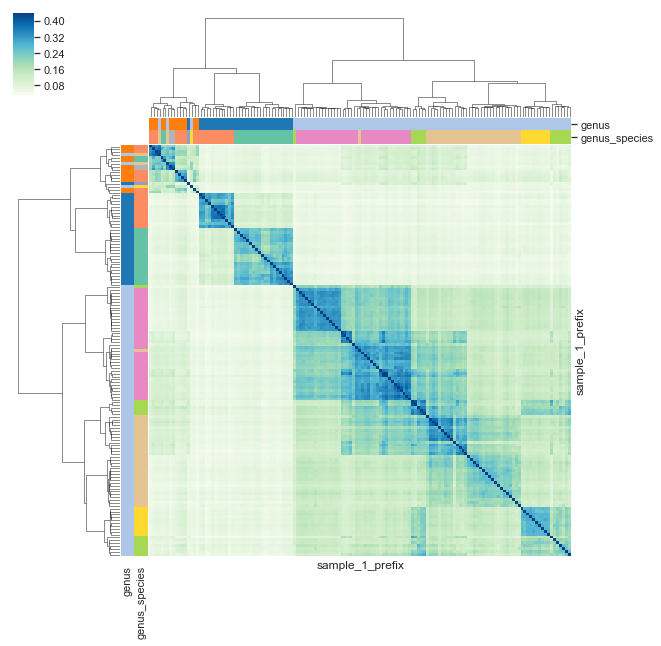

In [158]:
sourmash_utils.plaidplot_square(dd_tsv_pivot_24, species_id, 
                                metadata_col= metadata_cols,
                                palette=palette
                                )

In [ ]:
from khtools import knn

g = knn.nearest_neighbor_graph(dd_tsv_pivot, species_id, color_cols=metadata_cols, palettes=palette)


In [ ]:
knn.draw_graph(g, "genus_species")

In [ ]:
mkdir ../figures

In [ ]:
overlapping_samples = species_id.index.intersection(dd_tsv_pivot.index)
data = dd_tsv_pivot.loc[overlapping_samples, overlapping_samples]
print(data.shape)

metadata = species_id.loc[overlapping_samples, ]
print(metadata.shape)

In [ ]:
len(metadata.genus_species.unique())

In [ ]:
metadata_cols =["genus", 'genus_species']
palette=dict(genus="tab20", genus_species='Set2')

# sourmash_utils.plaidplot_square(dd_tsv_pivot, species_id, 
#                                 metadata_col= metadata_cols,
#                                 palette=palette
#                                 )




In [ ]:
sourmash_utils.plaidplot_and_distplot(data, 
                                      metadata, 
                                      "mosquitoes", 
                                      "33", 
                                      ignore_abundance=False, 
                                      molecule="DNA",
                                      metadata_col= 'genus_species',
                                      palette='tab10', 
                                      cell_id="CMS_021_RNA_A_S16_001"
                                     )
